# QC: Registration Module Validation

This notebook validates the `starfinder.registration` module for phase correlation-based image registration.

In [1]:
import sys
sys.path.insert(0, "../src/python")

import json
import numpy as np
from pathlib import Path

from starfinder.registration import (
    phase_correlate,
    apply_shift,
    register_volume,
    phase_correlate_skimage,
)
from starfinder.registration.benchmark import benchmark_registration, print_benchmark_table
from starfinder.testdata import create_test_volume
from starfinder.io import load_image_stacks

print("Imports successful")

Imports successful


## 1. Test Known Shift Recovery

Create a test volume, apply a known shift, and verify the recovered shift matches.

In [2]:
# Create test volume with synthetic spots
fixed = create_test_volume(
    shape=(10, 128, 128),
    n_spots=30,
    spot_intensity=200,
    background=20,
    seed=42,
)

print(f"Fixed volume shape: {fixed.shape}")
print(f"Fixed volume dtype: {fixed.dtype}")
print(f"Fixed volume range: [{fixed.min()}, {fixed.max()}]")

# Apply known shift using np.roll
known_shift = (2, -5, 8)  # (dz, dy, dx)
moving = np.roll(fixed, known_shift, axis=(0, 1, 2))

print(f"\nApplied known shift: {known_shift}")

# Recover shift using phase correlation
recovered_shift = phase_correlate(fixed, moving)

print(f"Recovered shift: {recovered_shift}")

# Verify
shift_error = np.sqrt(sum((r - k) ** 2 for r, k in zip(recovered_shift, known_shift)))
print(f"\nShift error (L2): {shift_error:.4f}")

assert shift_error < 0.5, f"Shift error too large: {shift_error}"
print("PASS: Known shift recovered correctly")

Fixed volume shape: (10, 128, 128)
Fixed volume dtype: uint8
Fixed volume range: [0, 255]

Applied known shift: (2, -5, 8)
Recovered shift: (2.0, -5.0, 8.0)

Shift error (L2): 0.0000
PASS: Known shift recovered correctly


## 2. Test apply_shift() Edge Zeroing

Apply a shift to a constant volume and verify that edges are zeroed out (not wrapped).

In [3]:
# Create a constant volume (all 100s)
constant_volume = np.ones((10, 64, 64), dtype=np.float32) * 100

# Apply positive shift
shift_positive = (2, 5, 3)
shifted_pos = apply_shift(constant_volume, shift_positive)

print(f"Shift: {shift_positive}")
print(f"Result shape: {shifted_pos.shape}")

# Check that leading edges are zeroed
assert np.allclose(shifted_pos[:2, :, :], 0), "Z leading edge should be zero"
assert np.allclose(shifted_pos[:, :5, :], 0), "Y leading edge should be zero"
assert np.allclose(shifted_pos[:, :, :3], 0), "X leading edge should be zero"

# Check that interior is non-zero
interior = shifted_pos[3:, 6:, 4:]
assert interior.mean() > 50, "Interior should be non-zero"

print("PASS: Positive shift - leading edges zeroed correctly")

# Apply negative shift
shift_negative = (-3, -4, -6)
shifted_neg = apply_shift(constant_volume, shift_negative)

print(f"\nShift: {shift_negative}")

# Check that trailing edges are zeroed
assert np.allclose(shifted_neg[-2:, :, :], 0), "Z trailing edge should be zero"
assert np.allclose(shifted_neg[:, -3:, :], 0), "Y trailing edge should be zero"
assert np.allclose(shifted_neg[:, :, -5:], 0), "X trailing edge should be zero"

print("PASS: Negative shift - trailing edges zeroed correctly")

Shift: (2, 5, 3)
Result shape: (10, 64, 64)
PASS: Positive shift - leading edges zeroed correctly

Shift: (-3, -4, -6)
PASS: Negative shift - trailing edges zeroed correctly


## 3. Multi-Channel Registration

Test `register_volume()` with (Z, Y, X, C) input.

In [4]:
# Create multi-channel volume (Z, Y, X, C)
n_channels = 4
shape_3d = (10, 128, 128)

# Create base volume
base = create_test_volume(
    shape=shape_3d,
    n_spots=25,
    spot_intensity=200,
    background=20,
    seed=123,
)

# Create multi-channel by adding noise to each channel
rng = np.random.default_rng(42)
multi_channel = np.stack(
    [base + rng.integers(0, 20, base.shape, dtype=np.uint8) for _ in range(n_channels)],
    axis=-1
)

print(f"Multi-channel volume shape: {multi_channel.shape}")
assert multi_channel.shape == (*shape_3d, n_channels)

# Create reference and moving (use channel 0 for shift calculation)
ref_image = base
known_shift = (-3, 4, -2)
mov_image = np.roll(base, known_shift, axis=(0, 1, 2))

# Apply same shift to all channels to simulate misaligned data
shifted_multi = np.stack(
    [np.roll(multi_channel[:, :, :, c], known_shift, axis=(0, 1, 2)) for c in range(n_channels)],
    axis=-1
)

print(f"Shifted multi-channel shape: {shifted_multi.shape}")

# Register
registered, detected_shift = register_volume(shifted_multi, ref_image, mov_image)

print(f"\nKnown shift: {known_shift}")
print(f"Detected shift: {detected_shift}")
print(f"Registered shape: {registered.shape}")

# Verify shift detection
shift_error = np.sqrt(sum((d - k) ** 2 for d, k in zip(detected_shift, known_shift)))
print(f"Shift error: {shift_error:.4f}")

assert shift_error < 0.5, f"Shift error too large: {shift_error}"
assert registered.shape == multi_channel.shape, "Output shape should match input"

print("\nPASS: Multi-channel registration works correctly")

Multi-channel volume shape: (10, 128, 128, 4)
Shifted multi-channel shape: (10, 128, 128, 4)

Known shift: (-3, 4, -2)
Detected shift: (-3.0, 4.0, -2.0)
Registered shape: (10, 128, 128, 4)
Shift error: 0.0000

PASS: Multi-channel registration works correctly


## 4. Backend Comparison

Compare NumPy vs scikit-image backends using `benchmark_registration()`.

In [5]:
# Run benchmark with multiple sizes
results = benchmark_registration(
    sizes=[
        (5, 64, 64),      # tiny
        (10, 128, 128),   # small
        (20, 256, 256),   # medium
    ],
    methods=["numpy", "skimage"],
    n_runs=3,
    seed=42,
)

# Print formatted table
print_benchmark_table(results)

# Verify both methods recover shifts correctly
for r in results:
    assert r.metrics["shift_error"] < 0.5, f"{r.method} has large shift error: {r.metrics['shift_error']}"

print("PASS: Both backends recover shifts accurately")


| Method  | Size           | Time (s) | Memory (MB) | Shift Error |
|---------|----------------|----------|-------------|-------------|
| numpy   | 64×64×5        |    0.001 |         0.8 |        0.00 |
| skimage | 64×64×5        |    0.001 |         1.6 |        0.00 |
| numpy   | 128×128×10     |    0.006 |         6.3 |        0.00 |
| skimage | 128×128×10     |    0.012 |        12.6 |        0.00 |
| numpy   | 256×256×20     |    0.041 |        50.0 |        0.00 |
| skimage | 256×256×20     |    0.105 |       100.1 |        0.00 |

PASS: Both backends recover shifts accurately


## 5. Registration Visualization (Before/After)

Visualize registration quality using composite images:
- **Green** = Fixed image (reference)
- **Magenta** = Moving/Registered image

Good alignment shows **white/gray** where images overlap (green + magenta = white).

Known shift: (2, -5, 8)
Detected shift: (2.0, -5.0, 8.0)
Correction applied: (-2.0, 5.0, -8.0)


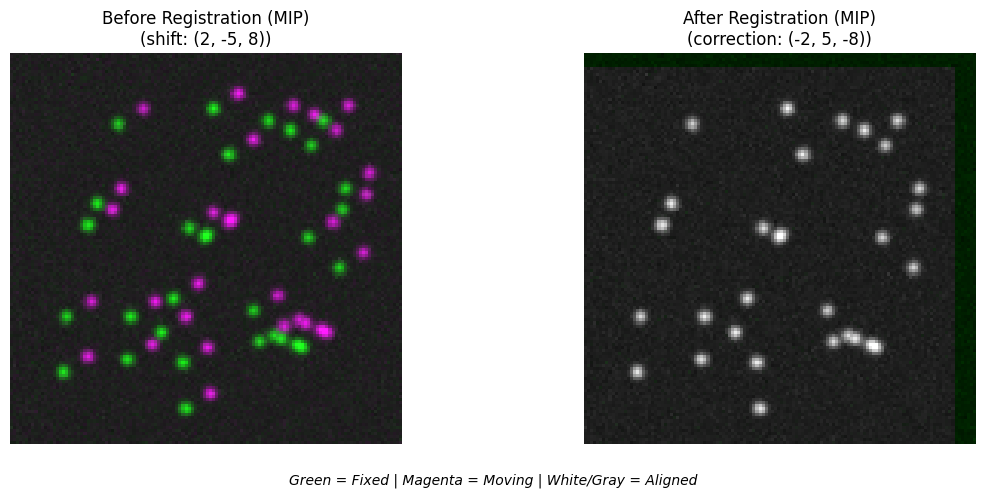


Interpretation:
- BEFORE: Green/magenta fringing indicates misalignment
- AFTER: White/gray regions indicate successful alignment


In [6]:
import matplotlib.pyplot as plt

def make_composite(green_img, magenta_img):
    """Create RGB composite: green channel + magenta (R+B) channel."""
    # Normalize to 0-1 range
    green_norm = green_img.astype(np.float32) / green_img.max()
    magenta_norm = magenta_img.astype(np.float32) / magenta_img.max()
    
    # Build RGB: magenta = R + B, green = G
    rgb = np.stack([
        magenta_norm,  # R
        green_norm,    # G
        magenta_norm,  # B
    ], axis=-1)
    
    return np.clip(rgb, 0, 1)

# Create test data
fixed = create_test_volume(
    shape=(10, 128, 128),
    n_spots=30,
    spot_intensity=200,
    background=20,
    seed=42,
)

known_shift = (2, -5, 8)
moving = np.roll(fixed, known_shift, axis=(0, 1, 2))

# Detect shift (returns how much moving is shifted from fixed)
detected_shift = phase_correlate(fixed, moving)

# Apply NEGATIVE shift to correct the alignment
correction = tuple(-s for s in detected_shift)
registered = apply_shift(moving, correction)

print(f"Known shift: {known_shift}")
print(f"Detected shift: {detected_shift}")
print(f"Correction applied: {correction}")

# Maximum intensity projection along Z-axis
fixed_mip = np.max(fixed, axis=0)
moving_mip = np.max(moving, axis=0)
registered_mip = np.max(registered, axis=0)

# Create composites
composite_before = make_composite(fixed_mip, moving_mip)
composite_after = make_composite(fixed_mip, registered_mip)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].imshow(composite_before)
axes[0].set_title(f"Before Registration (MIP)\n(shift: {known_shift})")
axes[0].axis("off")

axes[1].imshow(composite_after)
axes[1].set_title(f"After Registration (MIP)\n(correction: {tuple(int(s) for s in correction)})")
axes[1].axis("off")

# Add color legend
fig.text(0.5, 0.02, "Green = Fixed | Magenta = Moving | White/Gray = Aligned", 
         ha="center", fontsize=10, style="italic")

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)
plt.show()

print("\nInterpretation:")
print("- BEFORE: Green/magenta fringing indicates misalignment")
print("- AFTER: White/gray regions indicate successful alignment")

## 6. Test with Synthetic Dataset Shifts

Load ground_truth.json from the mini dataset, register rounds, and compare to expected shifts.

Ground truth shifts:
  round1: [0, 0, 0]
  round2: [-2, 3, 2]
  round3: [0, -1, 4]
  round4: [-2, 2, -3]

Reference stack shape: (10, 512, 512, 4)
Reference MIP shape: (10, 512, 512)

Registration results:
------------------------------------------------------------
round2:
  Expected: (-2, 3, 2)
  Detected: (-2, 3, 2)
  Error: 0.00 [PASS]
round3:
  Expected: (0, -1, 4)
  Detected: (0, -1, 4)
  Error: 0.00 [PASS]
round4:
  Expected: (-2, 2, -3)
  Detected: (-2, 2, -3)
  Error: 0.00 [PASS]
------------------------------------------------------------

Note: Using max projection across all channels for robust shift detection.


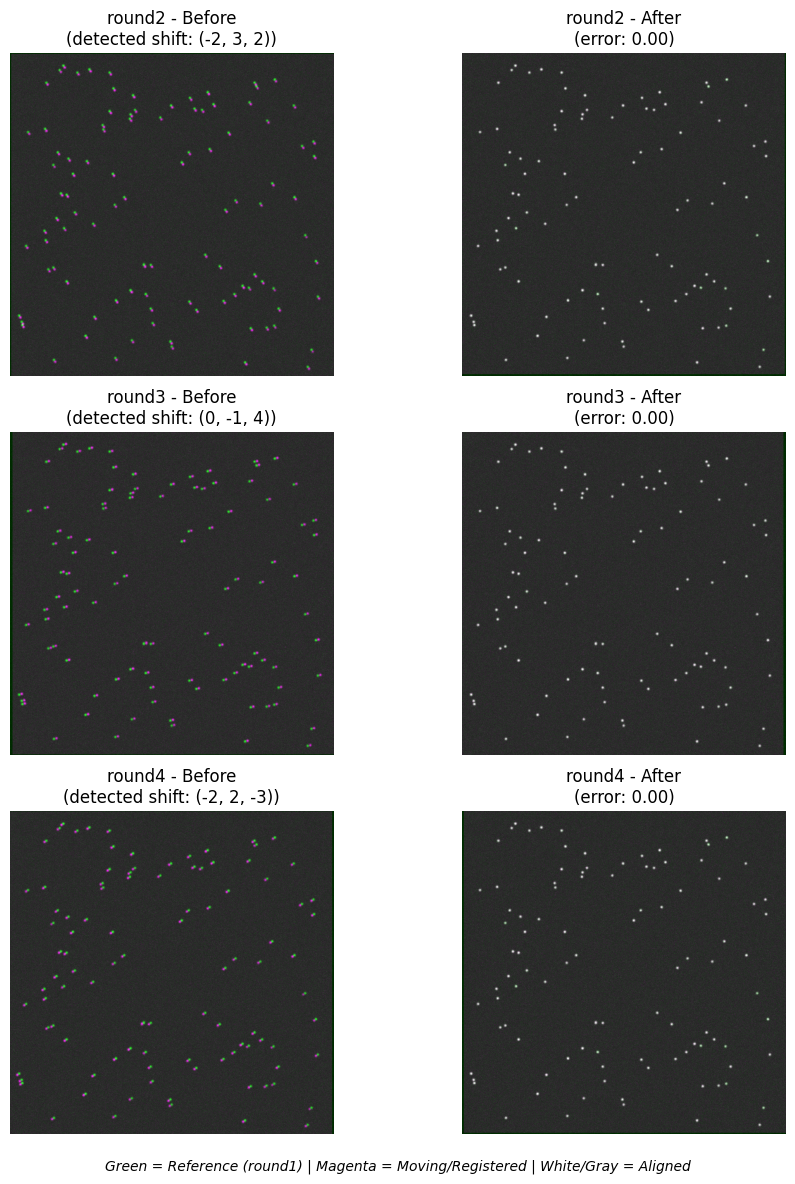

In [9]:
# Load ground truth
mini_path = Path("tests/fixtures/synthetic/standard")
with open(mini_path / "ground_truth.json") as f:
    ground_truth = json.load(f)

print("Ground truth shifts:")
expected_shifts = ground_truth["fovs"]["FOV_001"]["shifts"]
for round_name, shift in expected_shifts.items():
    print(f"  {round_name}: {shift}")

# Load reference round (round1)
channel_order = ["ch00", "ch01", "ch02", "ch03"]
ref_stack, _ = load_image_stacks(
    mini_path / "FOV_001" / "round1",
    channel_order=channel_order,
)

print(f"\nReference stack shape: {ref_stack.shape}")

# Use maximum projection across all channels as reference (Z, Y, X)
ref_mip = np.max(ref_stack, axis=-1)
print(f"Reference MIP shape: {ref_mip.shape}")

# For visualization: MIP along Z of the reference
ref_mip_z = np.max(ref_mip, axis=0)  # (Y, X)

# Register each round and compare to expected shifts
print("\nRegistration results:")
print("-" * 60)

# Collect results for visualization
vis_data = []

for round_idx in range(2, 5):  # rounds 2, 3, 4
    round_name = f"round{round_idx}"
    
    # Load moving round
    mov_stack, _ = load_image_stacks(
        mini_path / "FOV_001" / round_name,
        channel_order=channel_order,
    )
    
    # Use maximum projection across all channels as moving image
    mov_mip = np.max(mov_stack, axis=-1)
    
    # Detect shift
    detected = phase_correlate(ref_mip, mov_mip)
    expected = tuple(expected_shifts[round_name])
    
    # Apply correction
    correction = tuple(-s for s in detected)
    registered_mip = apply_shift(mov_mip, correction)
    
    # Calculate error
    error = np.sqrt(sum((d - e) ** 2 for d, e in zip(detected, expected)))
    status = "PASS" if error < 1.0 else "FAIL"
    
    print(f"{round_name}:")
    print(f"  Expected: {expected}")
    print(f"  Detected: {tuple(int(d) for d in detected)}")
    print(f"  Error: {error:.2f} [{status}]")
    
    # Store for visualization (MIP along Z)
    vis_data.append({
        "round": round_name,
        "moving_mip_z": np.max(mov_mip, axis=0),
        "registered_mip_z": np.max(registered_mip, axis=0),
        "detected": detected,
        "error": error,
    })

print("-" * 60)
print("\nNote: Using max projection across all channels for robust shift detection.")

# Visualization: Before/After for each round
fig, axes = plt.subplots(len(vis_data), 2, figsize=(10, 4 * len(vis_data)))

for i, data in enumerate(vis_data):
    # Before registration
    composite_before = make_composite(ref_mip_z, data["moving_mip_z"])
    axes[i, 0].imshow(composite_before)
    axes[i, 0].set_title(f"{data['round']} - Before\n(detected shift: {tuple(int(s) for s in data['detected'])})")
    axes[i, 0].axis("off")
    
    # After registration
    composite_after = make_composite(ref_mip_z, data["registered_mip_z"])
    axes[i, 1].imshow(composite_after)
    axes[i, 1].set_title(f"{data['round']} - After\n(error: {data['error']:.2f})")
    axes[i, 1].axis("off")

# Add color legend
fig.text(0.5, 0.02, "Green = Reference (round1) | Magenta = Moving/Registered | White/Gray = Aligned", 
         ha="center", fontsize=10, style="italic")

plt.tight_layout()
plt.subplots_adjust(bottom=0.05)
plt.show()

## 7. Local (Non-Rigid) Registration

This section demonstrates when local registration is needed vs global-only.

### 7.1 Create Synthetic Local Deformation

In [ ]:
from scipy.ndimage import map_coordinates, gaussian_filter

def create_local_deformation(volume, strength=5.0, seed=42):
    """Apply smooth spatially-varying deformation (simulates tissue warping)."""
    rng = np.random.default_rng(seed)
    field = rng.standard_normal((3, *volume.shape)) * strength
    field = gaussian_filter(field, sigma=[0, 10, 10, 10])
    coords = np.meshgrid(*[np.arange(s) for s in volume.shape], indexing='ij')
    warped_coords = [c + f for c, f in zip(coords, field)]
    deformed = map_coordinates(volume, warped_coords, order=1, mode='constant', cval=0)
    return deformed, field.transpose(1, 2, 3, 0)

# Apply local deformation to reference volume
ref_volume = ref_stack[:, :, :, 0]
deformed, true_field = create_local_deformation(ref_volume, strength=8.0)
print(f"Reference shape: {ref_volume.shape}")
print(f"Max deformation: {np.abs(true_field).max():.2f} pixels")

### 7.2 Global Registration Fails on Local Deformation

In [ ]:
from starfinder.registration import register_volume

deformed_4d = deformed[..., np.newaxis]
global_registered, shifts = register_volume(deformed_4d, ref_volume, deformed)
print(f"Global detected shift: {shifts}")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
composite_before = make_composite(ref_volume.max(axis=0), deformed.max(axis=0))
axes[0].imshow(composite_before)
axes[0].set_title('Before: Ref (green) vs Deformed (magenta)')
composite_global = make_composite(ref_volume.max(axis=0), global_registered[:,:,:,0].max(axis=0))
axes[1].imshow(composite_global)
axes[1].set_title(f'After GLOBAL registration (shift={shifts})')
plt.tight_layout()
plt.show()

### 7.3 Local Registration Succeeds

In [ ]:
try:
    from starfinder.registration import register_volume_local
    
    local_registered, estimated_field = register_volume_local(
        deformed_4d, ref_volume, deformed,
        iterations=[100, 50, 25], smoothing_sigma=1.0,
    )
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    composite_local = make_composite(ref_volume.max(axis=0), local_registered[:,:,:,0].max(axis=0))
    axes[0].imshow(composite_local)
    axes[0].set_title('After LOCAL registration')
    
    diff_global = np.abs(ref_volume - global_registered[:,:,:,0]).max(axis=0)
    diff_local = np.abs(ref_volume - local_registered[:,:,:,0]).max(axis=0)
    axes[1].imshow(diff_global, cmap='hot', vmin=0, vmax=diff_global.max())
    axes[1].set_title(f'Global error (mean={diff_global.mean():.2f})')
    axes[2].imshow(diff_local, cmap='hot', vmin=0, vmax=diff_global.max())
    axes[2].set_title(f'Local error (mean={diff_local.mean():.2f})')
    plt.tight_layout()
    plt.show()
    
    print(f"Improvement: {(1 - diff_local.mean()/diff_global.mean())*100:.1f}%")
except ImportError as e:
    print(f"SimpleITK not installed: {e}")
    print("Install with: uv add 'starfinder[local-registration]'")

### 7.4 Displacement Field Visualization

In [ ]:
try:
    field_magnitude = np.linalg.norm(estimated_field, axis=-1)
    true_magnitude = np.linalg.norm(true_field, axis=-1)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    im0 = axes[0].imshow(true_magnitude.max(axis=0), cmap='hot')
    axes[0].set_title('True Displacement (MIP)')
    plt.colorbar(im0, ax=axes[0], label='pixels')
    im1 = axes[1].imshow(field_magnitude.max(axis=0), cmap='hot')
    axes[1].set_title('Estimated Displacement (MIP)')
    plt.colorbar(im1, ax=axes[1], label='pixels')
    plt.tight_layout()
    plt.show()
except NameError:
    print("Run local registration cell first")

## Summary

**Validation Checklist:**

- [ ] `phase_correlate()` recovers known shifts accurately
- [ ] `apply_shift()` zeros out edges (no wrap-around artifacts)
- [ ] `register_volume()` handles multi-channel (Z, Y, X, C) input
- [ ] NumPy and scikit-image backends produce consistent results
- [ ] Matplotlib composite shows good alignment (white/gray = green + magenta)
- [ ] Registration works with synthetic dataset ground truth shifts